## 

# 2. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
2-dim output

## 

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE, VGAE, LayerNorm
from torch_geometric.utils import train_test_split_edges
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BasicVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicVGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2_mu = GCNConv(2 * out_channels, out_channels)
        self.conv2_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)

dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
data = train_test_split_edges(data)

# Model initialization
in_channels = dataset.num_features
out_channels = 2
model = VGAE(BasicVGAEEncoder(in_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the VGAE model
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the GNN model for node classification
hidden_channels = 16
num_classes = dataset.num_classes
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    print(f'Accuracy: {acc.item()}')


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.5226542949676514
Epoch: 20, Loss: 1.4217712879180908
Epoch: 30, Loss: 1.3881287574768066
Epoch: 40, Loss: 1.3641371726989746
Epoch: 50, Loss: 1.354231595993042
Epoch: 60, Loss: 1.3404111862182617
Epoch: 70, Loss: 1.3272626399993896
Epoch: 80, Loss: 1.3197523355484009
Epoch: 90, Loss: 1.3092331886291504
Epoch: 100, Loss: 1.3002867698669434
Epoch 0, Loss: 1.9593024253845215
Epoch 10, Loss: 1.937370777130127
Epoch 20, Loss: 1.9185420274734497
Epoch 30, Loss: 1.887974739074707
Epoch 40, Loss: 1.8587459325790405
Epoch 50, Loss: 1.8272953033447266
Epoch 60, Loss: 1.8169244527816772
Epoch 70, Loss: 1.805387020111084
Epoch 80, Loss: 1.818192481994629
Epoch 90, Loss: 1.8155156373977661
Accuracy: 0.18200001120567322


## 

In [2]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.1820


# 3. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
16-dim output

## 

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class BasicVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicVGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2_mu = GCNConv(2 * out_channels, out_channels)
        self.conv2_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)


dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 16
num_features = dataset.num_features
num_classes = dataset.num_classes
epochs = 100
hidden_channels = 32

# Model initialization
model = VGAE(BasicVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    


Epoch: 10, Loss: 1.8939505815505981
Epoch: 20, Loss: 1.3769333362579346
Epoch: 30, Loss: 1.3429733514785767
Epoch: 40, Loss: 1.3273588418960571
Epoch: 50, Loss: 1.3168079853057861
Epoch: 60, Loss: 1.3023473024368286
Epoch: 70, Loss: 1.2692617177963257
Epoch: 80, Loss: 1.2066574096679688
Epoch: 90, Loss: 1.1695829629898071
Epoch: 100, Loss: 1.130814552307129
Epoch 0, Loss: 1.9837417602539062
Epoch 10, Loss: 1.7810510396957397
Epoch 20, Loss: 1.6815341711044312
Epoch 30, Loss: 1.5901862382888794
Epoch 40, Loss: 1.5117262601852417
Epoch 50, Loss: 1.4230436086654663
Epoch 60, Loss: 1.361293077468872
Epoch 70, Loss: 1.3320841789245605
Epoch 80, Loss: 1.2573461532592773
Epoch 90, Loss: 1.1873888969421387


## 

In [4]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.4950


# 4. Basic Graph AE for DR
super basic 2 GCNConv layers  
2-dim output straight for visualisation

## 

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
import matplotlib.pyplot as plt

class BasicVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicVGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2_mu = GCNConv(2 * out_channels, out_channels)
        self.conv2_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)


dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = dataset.num_features

model = VGAE(BasicVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 1.6924328804016113
Epoch: 20, Loss: 1.5720851421356201
Epoch: 30, Loss: 1.512628197669983
Epoch: 40, Loss: 1.4851629734039307
Epoch: 50, Loss: 1.459446907043457
Epoch: 60, Loss: 1.4314279556274414
Epoch: 70, Loss: 1.4114210605621338
Epoch: 80, Loss: 1.3779841661453247
Epoch: 90, Loss: 1.3524973392486572
Epoch: 100, Loss: 1.3277645111083984


## 

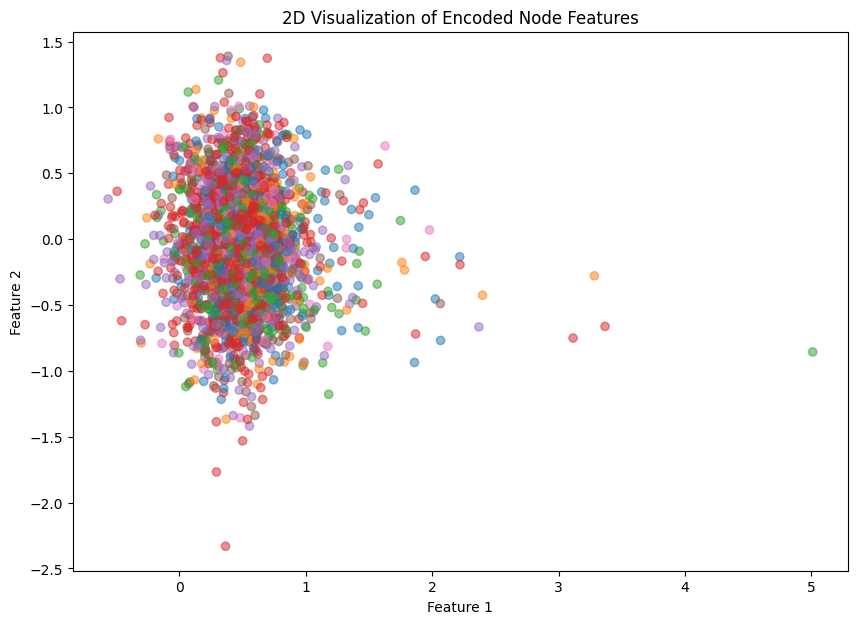

In [6]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 5. Basic Graph AE + tSNE
super basic 2 GCNConv layers  
16-dim output -> tSNE (2dim)

## 

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = dataset.num_features

# Model initialization
model = VGAE(BasicVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(encoded_features)



Epoch: 10, Loss: 2.0060408115386963
Epoch: 20, Loss: 1.3839693069458008
Epoch: 30, Loss: 1.3440215587615967
Epoch: 40, Loss: 1.337015151977539
Epoch: 50, Loss: 1.3292649984359741
Epoch: 60, Loss: 1.326209545135498
Epoch: 70, Loss: 1.328106164932251
Epoch: 80, Loss: 1.3208496570587158
Epoch: 90, Loss: 1.3245795965194702
Epoch: 100, Loss: 1.3191486597061157
Epoch: 110, Loss: 1.3123047351837158
Epoch: 120, Loss: 1.3121209144592285
Epoch: 130, Loss: 1.3049744367599487
Epoch: 140, Loss: 1.2943153381347656
Epoch: 150, Loss: 1.2742704153060913
Epoch: 160, Loss: 1.230018973350525
Epoch: 170, Loss: 1.1638803482055664
Epoch: 180, Loss: 1.1580915451049805
Epoch: 190, Loss: 1.1495765447616577
Epoch: 200, Loss: 1.145674228668213


## 

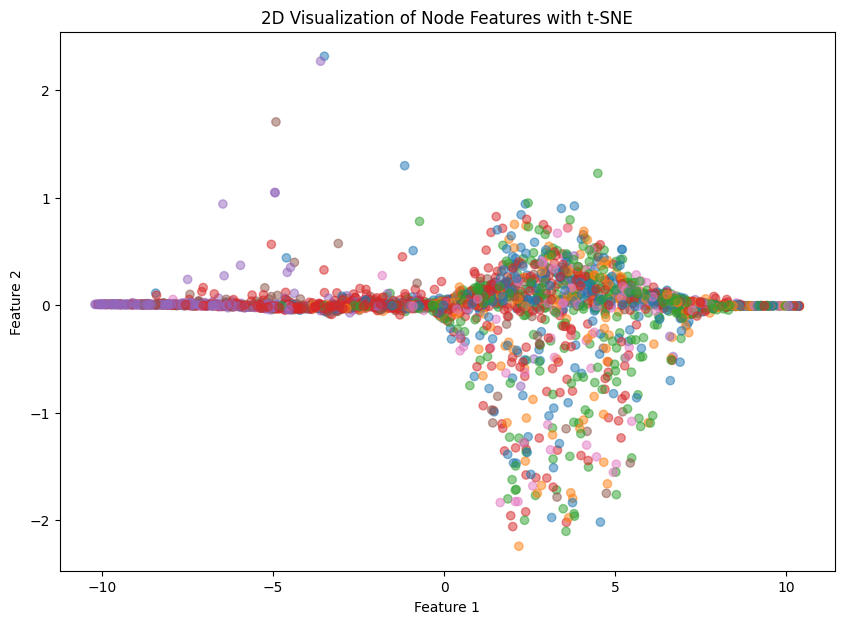

In [8]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 6. Graph AE with skip connections +tSNE
Three GCNConv layers with a skip connection

## 

In [9]:
class SkipVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SkipVGAEEncoder, self).__init__()
        self.base_conv1 = GCNConv(in_channels, 2 * out_channels)
        self.skip_conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2_mu = GCNConv(2 * out_channels, out_channels)
        self.conv2_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.base_conv1(x, edge_index))
        x = x + skip1
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)


# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = dataset.num_features

# Model initialization
model = VGAE(SkipVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 1.6669702529907227
Epoch: 20, Loss: 1.353224754333496
Epoch: 30, Loss: 1.333681583404541
Epoch: 40, Loss: 1.3173681497573853
Epoch: 50, Loss: 1.307449460029602
Epoch: 60, Loss: 1.293148159980774
Epoch: 70, Loss: 1.2502723932266235
Epoch: 80, Loss: 1.1710078716278076
Epoch: 90, Loss: 1.144062876701355
Epoch: 100, Loss: 1.1381641626358032
Epoch: 110, Loss: 1.1334930658340454
Epoch: 120, Loss: 1.1284172534942627
Epoch: 130, Loss: 1.1350048780441284
Epoch: 140, Loss: 1.1253331899642944
Epoch: 150, Loss: 1.1200281381607056
Epoch: 160, Loss: 1.1069811582565308
Epoch: 170, Loss: 1.1006996631622314
Epoch: 180, Loss: 1.1015678644180298
Epoch: 190, Loss: 1.0811911821365356
Epoch: 200, Loss: 1.049324631690979


## 

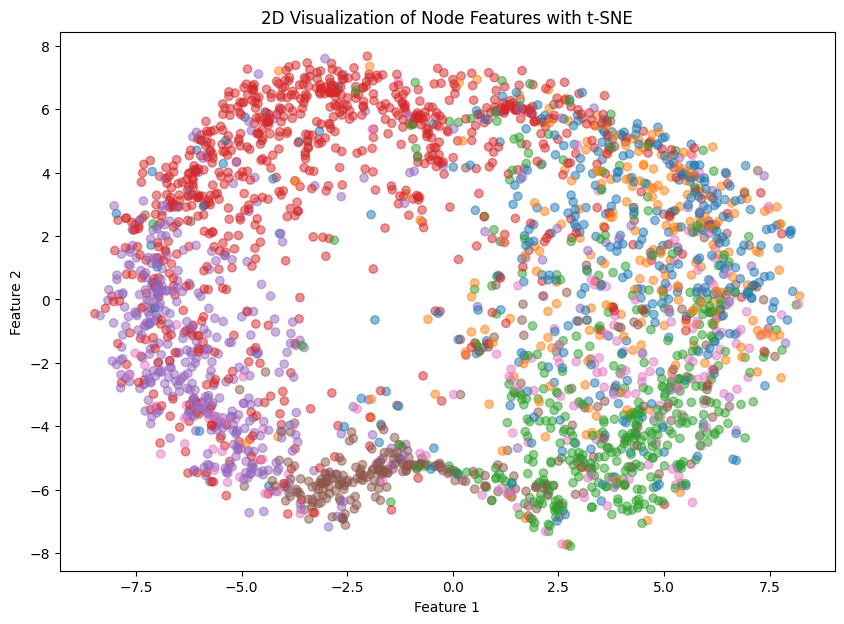

In [10]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 7. Graph AE with skip connections
Three GCNConv layers with a skip connection

## 

In [14]:
dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = dataset.num_features

model = VGAE(SkipVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 1.6033084392547607
Epoch: 20, Loss: 1.4809727668762207
Epoch: 30, Loss: 1.414705753326416
Epoch: 40, Loss: 1.3705902099609375
Epoch: 50, Loss: 1.3364169597625732
Epoch: 60, Loss: 1.3252190351486206
Epoch: 70, Loss: 1.3145323991775513
Epoch: 80, Loss: 1.2987427711486816
Epoch: 90, Loss: 1.2818186283111572
Epoch: 100, Loss: 1.2698010206222534


## 

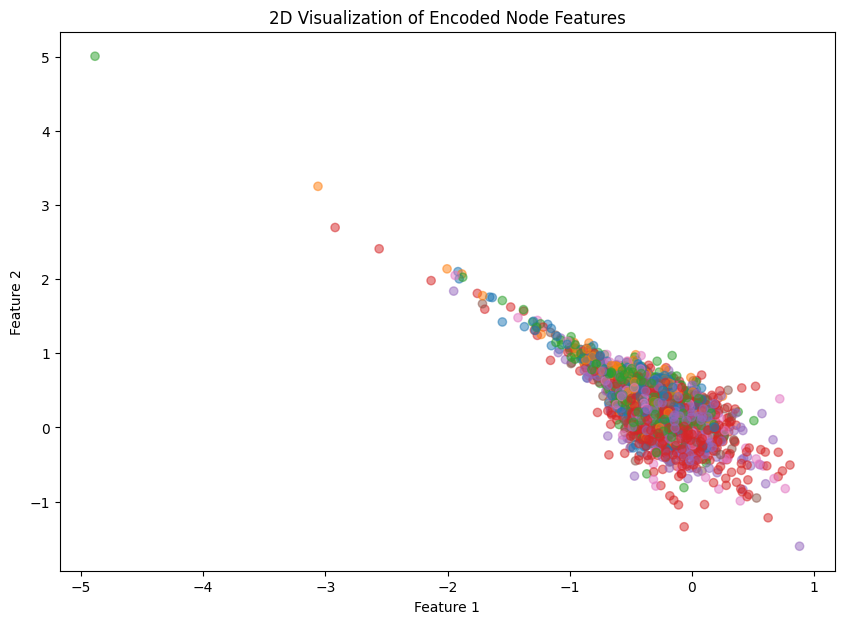

In [15]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')


# 8. Graph AE with attention
Two GATConv layers.

## 

In [16]:
from torch_geometric.nn import GATConv

class GATVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATVGAEEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=8, dropout=0.6)
        self.conv2_mu = GATConv(2 * out_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)
        self.conv2_logstd = GATConv(2 * out_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)


dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = dataset.num_features

model = VGAE(GATVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

Epoch: 10, Loss: 1.4286448955535889
Epoch: 20, Loss: 1.3987749814987183
Epoch: 30, Loss: 1.396291732788086
Epoch: 40, Loss: 1.3940777778625488
Epoch: 50, Loss: 1.3912146091461182
Epoch: 60, Loss: 1.3920977115631104
Epoch: 70, Loss: 1.3872147798538208
Epoch: 80, Loss: 1.3836923837661743
Epoch: 90, Loss: 1.3817218542099
Epoch: 100, Loss: 1.3728961944580078
Epoch: 110, Loss: 1.3572636842727661
Epoch: 120, Loss: 1.339184045791626
Epoch: 130, Loss: 1.3279041051864624
Epoch: 140, Loss: 1.3279527425765991
Epoch: 150, Loss: 1.3075765371322632
Epoch: 160, Loss: 1.2944453954696655
Epoch: 170, Loss: 1.3025083541870117
Epoch: 180, Loss: 1.292541742324829
Epoch: 190, Loss: 1.2985754013061523
Epoch: 200, Loss: 1.2887353897094727


## 

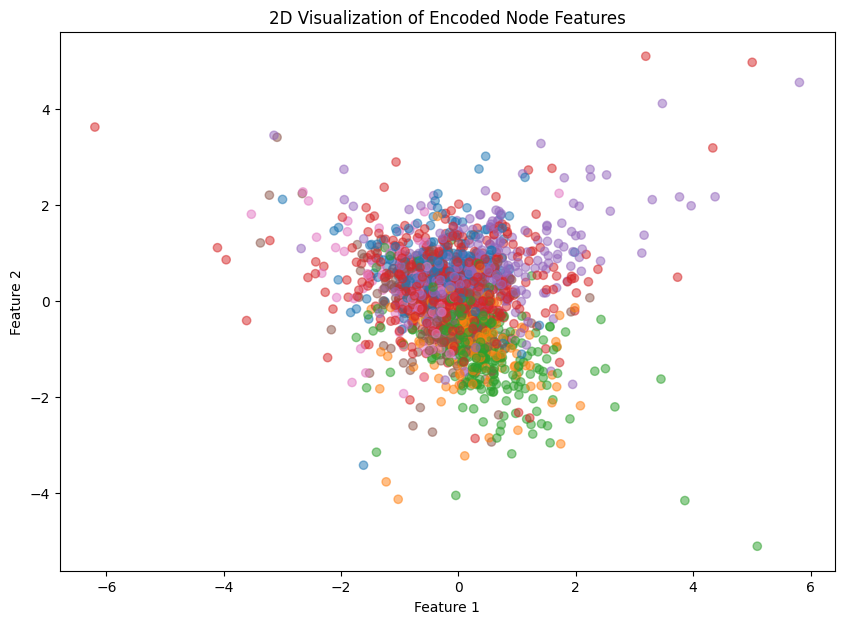

In [17]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 8. Graph AE with attention + tSNE
Two GATConv layers.

## 

In [19]:
# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = dataset.num_features

# Model initialization
model = VGAE(GATVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()




Epoch: 10, Loss: 1.4578990936279297
Epoch: 20, Loss: 1.4305882453918457
Epoch: 30, Loss: 1.4216208457946777
Epoch: 40, Loss: 1.4255056381225586
Epoch: 50, Loss: 1.4186058044433594
Epoch: 60, Loss: 1.4153894186019897
Epoch: 70, Loss: 1.419560432434082
Epoch: 80, Loss: 1.403104305267334
Epoch: 90, Loss: 1.4062893390655518
Epoch: 100, Loss: 1.4099563360214233
Epoch: 110, Loss: 1.4055652618408203
Epoch: 120, Loss: 1.4025225639343262
Epoch: 130, Loss: 1.3982006311416626
Epoch: 140, Loss: 1.3967666625976562
Epoch: 150, Loss: 1.3872623443603516
Epoch: 160, Loss: 1.3482539653778076
Epoch: 170, Loss: 1.3383030891418457
Epoch: 180, Loss: 1.3368799686431885
Epoch: 190, Loss: 1.364823818206787
Epoch: 200, Loss: 1.3360333442687988


## 

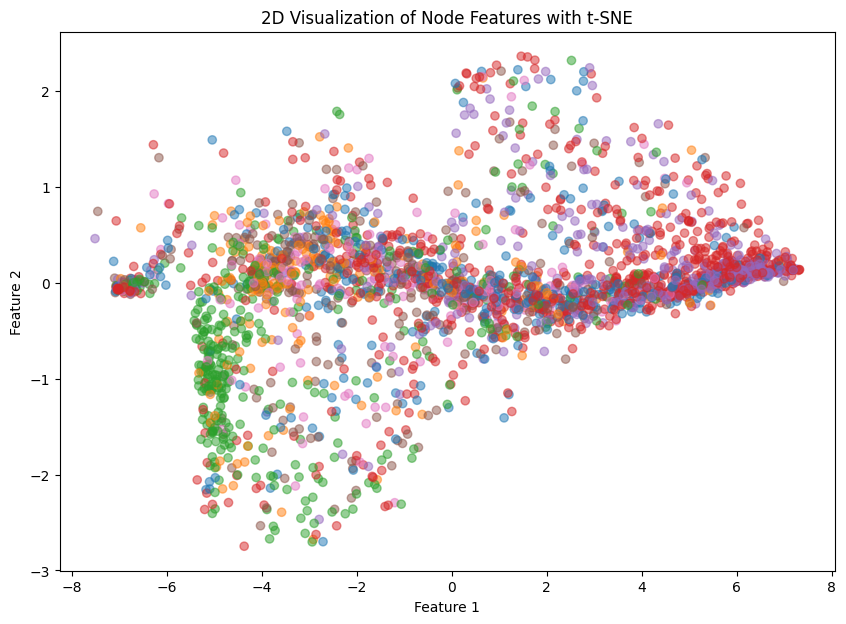

In [20]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 9. Graph AE with skip & residual connections
3 GCNConv layers with skip connections.

## 

In [22]:
class ResidualVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualVGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2_mu = GCNConv(2 * out_channels, out_channels)
        self.conv2_logstd = GCNConv(2 * out_channels, out_channels)
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x
        x = F.relu(self.conv1(x, edge_index))
        mu = self.conv2_mu(x, edge_index)
        logstd = self.conv2_logstd(x, edge_index)

        if identity.size(-1) != mu.size(-1):
            identity = self.shortcut(identity)

        mu += identity
        logstd += identity

        return mu, logstd


dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = dataset.num_features
hidden_channels=16

model = VGAE(ResidualVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 1.4691516160964966
Epoch: 20, Loss: 1.3991711139678955
Epoch: 30, Loss: 1.3687852621078491
Epoch: 40, Loss: 1.3419771194458008
Epoch: 50, Loss: 1.3120546340942383
Epoch: 60, Loss: 1.2822856903076172
Epoch: 70, Loss: 1.2348335981369019
Epoch: 80, Loss: 1.1840438842773438
Epoch: 90, Loss: 1.15773606300354
Epoch: 100, Loss: 1.1455045938491821
Epoch: 110, Loss: 1.1203252077102661
Epoch: 120, Loss: 1.1096093654632568
Epoch: 130, Loss: 1.1118704080581665
Epoch: 140, Loss: 1.1037192344665527
Epoch: 150, Loss: 1.0897341966629028
Epoch: 160, Loss: 1.0820674896240234
Epoch: 170, Loss: 1.069884181022644
Epoch: 180, Loss: 1.0531306266784668
Epoch: 190, Loss: 1.0373733043670654
Epoch: 200, Loss: 1.0270991325378418


## 

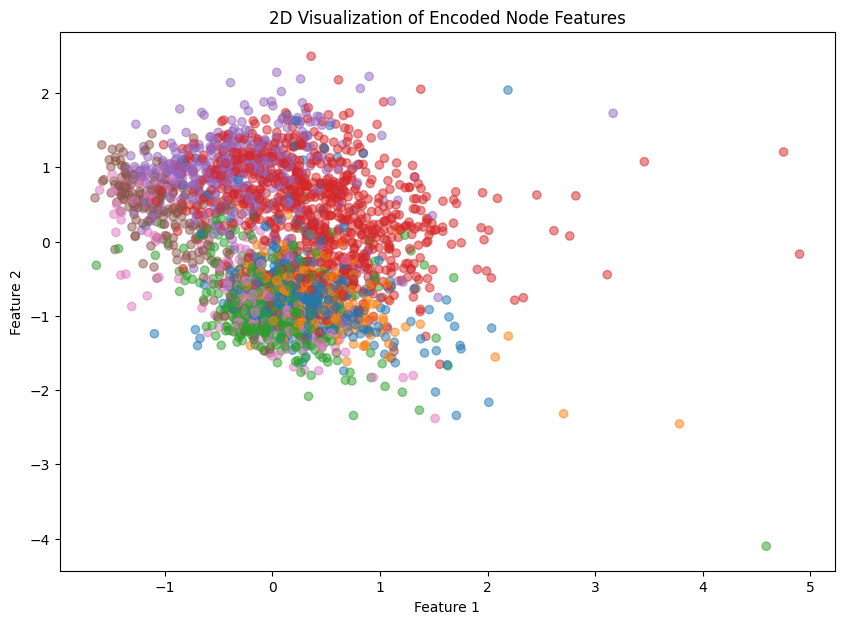

In [23]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 10. Graph AE with residual connection
Three GCNConv layers with a residual connection.

## 

In [27]:
from torch_geometric.nn import GCNConv, GAE, VGAE, LayerNorm

class EnhancedVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnhancedVGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.ln1 = LayerNorm(2 * out_channels)
        self.skip_conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2_mu = GCNConv(2 * out_channels, out_channels)
        self.conv2_logstd = GCNConv(2 * out_channels, out_channels)
        self.ln2_mu = LayerNorm(out_channels)
        self.ln2_logstd = LayerNorm(out_channels)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.conv1(x, edge_index))
        x = self.ln1(x + skip1)
        mu = self.conv2_mu(x, edge_index)
        logstd = self.conv2_logstd(x, edge_index)
        mu = self.ln2_mu(mu)
        logstd = self.ln2_logstd(logstd)
        return mu, logstd


dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = dataset.num_features
hidden_channels=16

model = VGAE(EnhancedVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 2.125535726547241
Epoch: 20, Loss: 1.891629934310913
Epoch: 30, Loss: 1.802963376045227
Epoch: 40, Loss: 1.719692587852478
Epoch: 50, Loss: 1.680187702178955
Epoch: 60, Loss: 1.6504406929016113
Epoch: 70, Loss: 1.6885234117507935
Epoch: 80, Loss: 1.6219775676727295
Epoch: 90, Loss: 1.663783073425293
Epoch: 100, Loss: 1.613551378250122
Epoch: 110, Loss: 1.618598461151123
Epoch: 120, Loss: 1.5816874504089355
Epoch: 130, Loss: 1.6115875244140625
Epoch: 140, Loss: 1.5699752569198608
Epoch: 150, Loss: 1.5894253253936768
Epoch: 160, Loss: 1.6098194122314453
Epoch: 170, Loss: 1.5718053579330444
Epoch: 180, Loss: 1.5764024257659912
Epoch: 190, Loss: 1.5455262660980225
Epoch: 200, Loss: 1.5536038875579834


## 

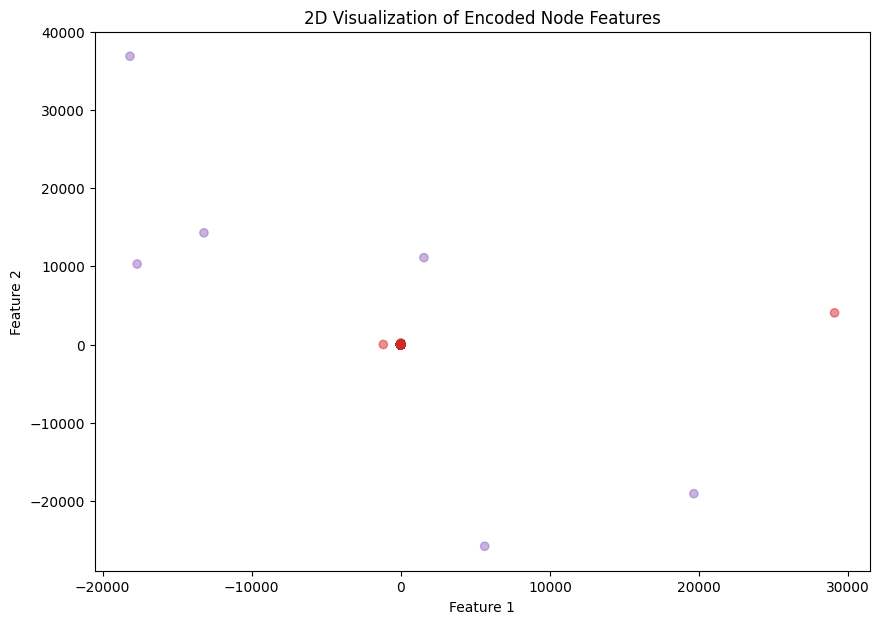

In [28]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 11. Graph AE with attention & normalization
Two GATConv layers with layer normalization.

## 

In [29]:
from torch_geometric.nn import GATConv, LayerNorm

class ComplexVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ComplexVGAEEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * 8, hidden_channels, heads=8, dropout=0.6)
        self.conv3_mu = GATConv(hidden_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)
        self.conv3_logstd = GATConv(hidden_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))

        mu = self.conv3_mu(x, edge_index)
        logstd = self.conv3_logstd(x, edge_index)

        if identity.size(-1) != mu.size(-1):
            identity = self.shortcut(identity)

        mu += identity
        logstd += identity

        return mu, logstd


dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = dataset.num_features
hidden_channels=16

model = VGAE(ComplexVGAEEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

labels = data.y.cpu().numpy()


Epoch: 10, Loss: 1.395076870918274
Epoch: 20, Loss: 1.3875336647033691
Epoch: 30, Loss: 1.3884501457214355
Epoch: 40, Loss: 1.3775758743286133
Epoch: 50, Loss: 1.3593204021453857
Epoch: 60, Loss: 1.2876429557800293
Epoch: 70, Loss: 1.2678933143615723
Epoch: 80, Loss: 1.2540709972381592
Epoch: 90, Loss: 1.2261710166931152
Epoch: 100, Loss: 1.211519479751587
Epoch: 110, Loss: 1.2044827938079834
Epoch: 120, Loss: 1.202836036682129
Epoch: 130, Loss: 1.1917765140533447
Epoch: 140, Loss: 1.17940092086792
Epoch: 150, Loss: 1.1744933128356934
Epoch: 160, Loss: 1.1532540321350098
Epoch: 170, Loss: 1.1654518842697144
Epoch: 180, Loss: 1.1473264694213867
Epoch: 190, Loss: 1.152756690979004
Epoch: 200, Loss: 1.141462802886963


## 

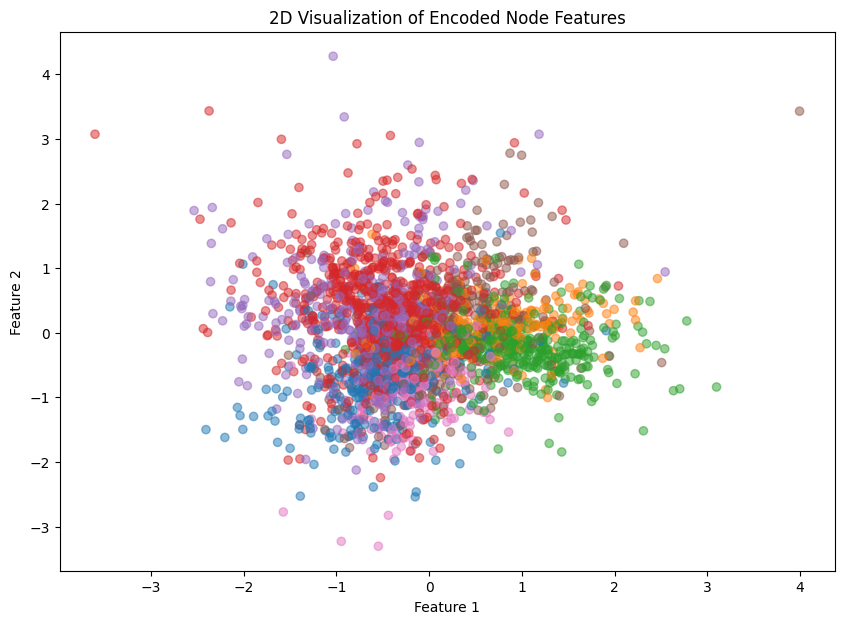

In [30]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')